C:\Users\dell\AppData\Local\Temp\ipykernel_7288\1745254789.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


C:\Users\dell\AppData\Local\Temp\ipykernel_7288\1745254789.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  file16 = pd.read_excel( r'D:\Ts\A1_16.xlsx',  # 使用原始字符串（r前缀）避免转义问题


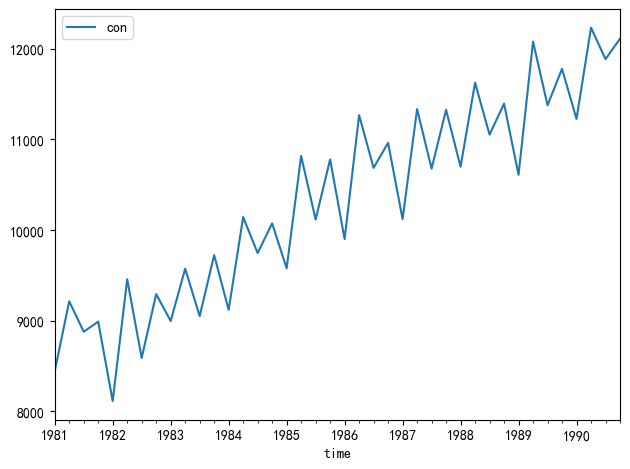

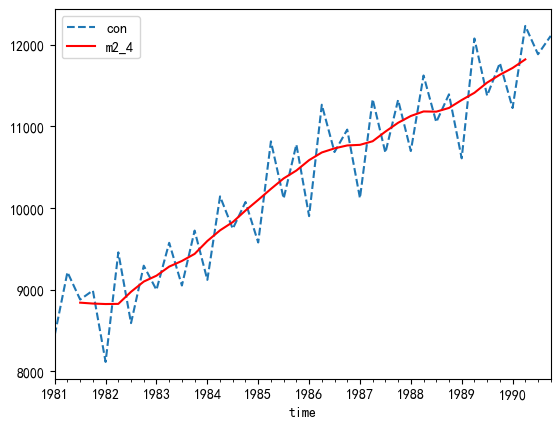

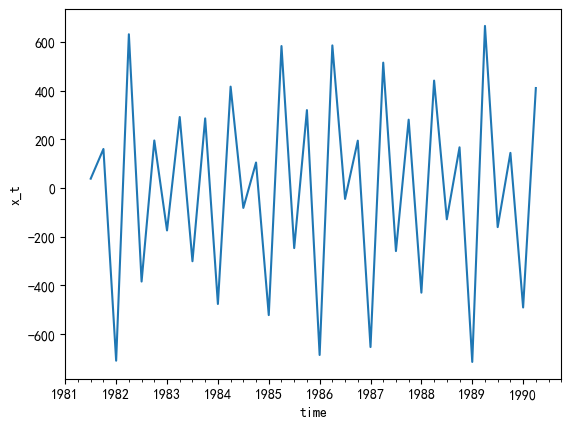

time
1   -539.513889
2    504.097222
3   -174.375000
4    205.555556
Name: con_t, dtype: float64
time
1   -539.513889
2    504.097222
3   -174.375000
4    205.555556
Name: con_t, dtype: float64
-1.0590277777777777
Index_season: time
1   -538.454861
2    505.156250
3   -173.315972
4    206.614583
Name: con_t, dtype: float64


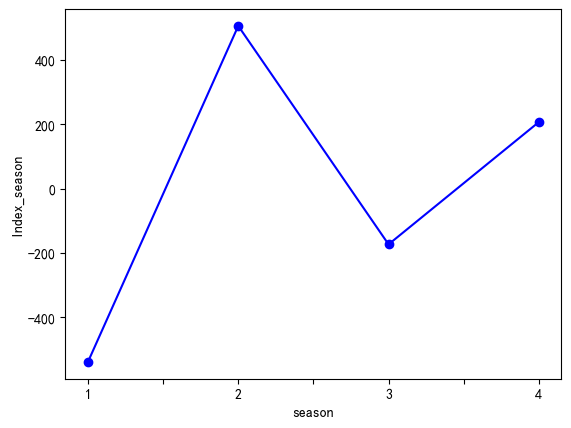

NaN values in Irr: 4


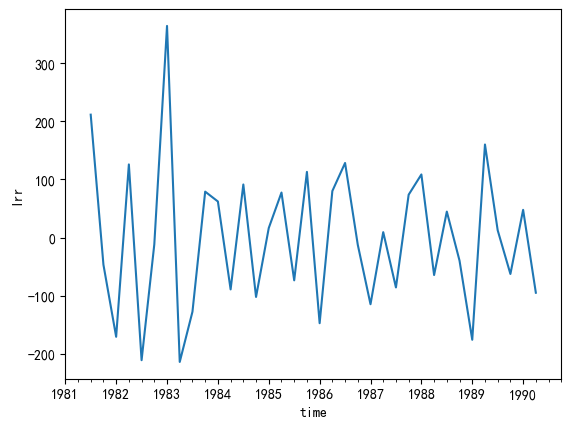

In [7]:
#例1  X11模型
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from matplotlib import rcParams   
from statsmodels.graphics.tsaplots import plot_acf  # 导入 plot_acf 函数
from statsmodels.graphics.tsaplots import plot_pacf  # 导入 plot_pacf 函数
from statsmodels.stats.diagnostic import acorr_ljungbox  
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.api import SARIMAX 
from statsmodels.tsa.stattools import arma_order_select_ic
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
# 设置输出单元格的高度
display(HTML("<style>.container { width:100% !important; }</style>"))

# 导入数据文件（注意路径中的反斜杠需转义或使用原始字符串）
file16 = pd.read_excel( r'D:\Ts\A1_16.xlsx',  # 使用原始字符串（r前缀）避免转义问题
    parse_dates=True,
    index_col=0
)
 #转换为周期索引（PeriodIndex）
file16 = file16.to_period('Q')  # 明确指定周期频率（如'Q'表示季度）

#  绘制时序图
file16.plot()
#  显示图形
plt.tight_layout()  # 自动调整布局
plt.show()

#做4期简单中心移动平均
file16["m4"]=file16.con.rolling(4, center = True).mean().shift(-1)
#做2x4复合移动平均
file16["m2_4"]=file16.m4.rolling(2, center = True).mean()
#显示原序列及移动平均计算结果
#print(file16)

#绘制移动平均效果图（见图)
file16.con.plot(linestyle="--")
file16.m2_4.plot(color="red") 
plt.legend(["con","m2_4"])
plt.show()  # 显示移动平均效果图

#绘制去掉趋势序列图（见图)
file16["con_t"]=file16.con-file16.m2_4
file16.con_t.plot(ylabel="x_t")
plt.show()  # 显示残差序列图

#计算序列的季度均值
mean_season=file16.con_t.groupby(file16.index.quarter).mean()
print(mean_season)
#计算序列的总均值
mean_all=file16.con_t.mean()
print(mean_season)
print(mean_all)
#计算季节指数（加法模型季节指数＝季节均值（季度均值）﹣总均值）
Index_season=mean_season-mean_all 
#输出季节指数（季度）
print("Index_season:",Index_season)

# 将索引转换为字符串类型
Index_season.index = Index_season.index.astype(str)

#季节指数图
Index_season.plot(ylabel="Index_season", xlabel="season", marker="o", color='b')
plt.show()  # 显示季节指数图


# 将索引转换为整数类型（关键修正）
Index_season.index = Index_season.index.astype(int)

# 将季节效应赋值给每个序列值
file16["Index_season"] = file16.index.quarter.map(Index_season)
# 计算随机效应
file16["Irr"] = file16.con - file16.m2_4 - file16.Index_season
# 检查 Irr 列是否存在 NaN 值
print("NaN values in Irr:", file16["Irr"].isna().sum())
# 绘制随机效应图
file16["Irr"].plot()
plt.ylabel("Irr")
plt.show()

In [8]:
#例1续  HoltWinter三参数模型
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']= False 
from statsmodels.tsa.api import ExponentialSmoothing 
import pandas as pd

fit_x = ExponentialSmoothing(
    file16.con, trend="add", seasonal="add", seasonal_periods=4
).fit()

# 打印参数以确认名称
#print(fit_x.params)
print(fit_x.summary())
# 映射参数名到常用记号
param_map = {
    'smoothing_level': 'alpha',
    'smoothing_trend': 'beta',
    'smoothing_seasonal': 'gamma'
}

# 提取并重命名参数
param_data = {
    v: fit_x.params[k] for k, v in param_map.items() if k in fit_x.params
}
# 添加SSE
param_data['SSE'] = fit_x.sse

# 创建DataFrame
x_params = pd.DataFrame({'fit(LSE)': param_data}).T  # .T 为参数在行
# 或者你喜欢参数名作为行索引
x_params = pd.DataFrame(
    {'fit(LSE)': [param_data.get('alpha'), param_data.get('beta'), param_data.get('gamma'), fit_x.sse]},
    index=['alpha', 'beta', 'gamma', 'SSE']
)

print(x_params)


l_1 = fit_x.level[-1]
t_1 = fit_x.trend[-1]
s_last_cycle = fit_x.season[-4:]
print('a(t)',l_1)
print('b(t)',t_1)
print('s_j(t)',s_last_cycle)

                       ExponentialSmoothing Model Results                       
Dep. Variable:                      con   No. Observations:                   40
Model:             ExponentialSmoothing   SSE                        1247788.283
Optimized:                         True   AIC                            429.920
Trend:                         Additive   BIC                            443.431
Seasonal:                      Additive   AICC                           437.506
Seasonal Periods:                     4   Date:                 Mon, 14 Jul 2025
Box-Cox:                          False   Time:                         15:22:00
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3493689                alpha                 True
smoothing_trend          

C:\Users\dell\AppData\Local\Temp\ipykernel_7288\3625830031.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  l_1 = fit_x.level[-1]
C:\Users\dell\AppData\Local\Temp\ipykernel_7288\3625830031.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_1 = fit_x.trend[-1]


1991Q1    11537.548422
1991Q2    12631.789092
1991Q3    12062.639220
1991Q4    12500.332374
1992Q1    11870.268683
1992Q2    12964.509354
1992Q3    12395.359482
1992Q4    12833.052636
Freq: Q-DEC, dtype: float64


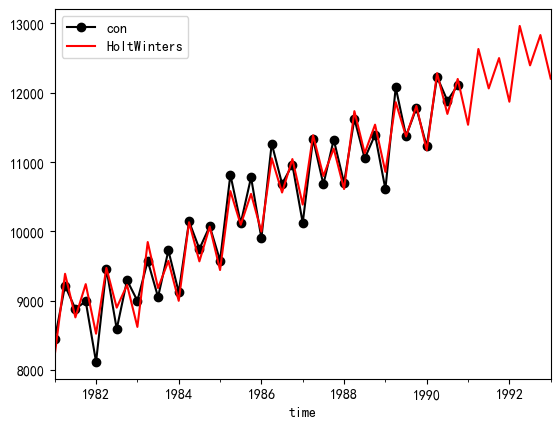

In [9]:
#基于 Holt - Winters 三参数指数平滑模型，进行8期预测，并输出预测结果

pred=fit_x.predict(0,len (file16)+8)
print(pred[len(file16):len(file16)+8])

#绘制预测效果图（见图6-16
file16.con.plot (color="black", marker ="o", legend=True )
pred.plot(color="red",legend=True, label="HoltWinters")
plt.show()

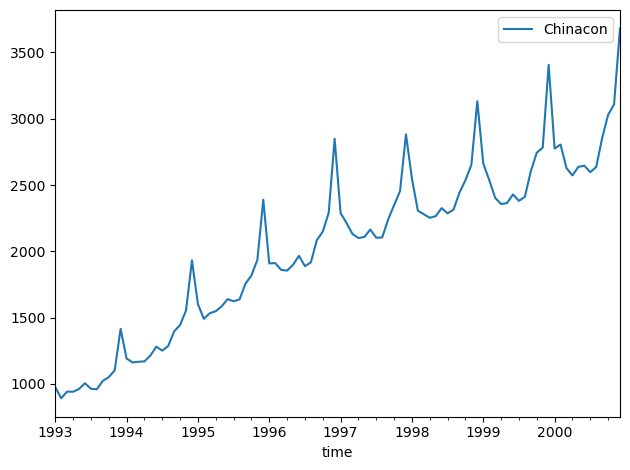

         Chinacon          m12        m2_12
time                                       
1993-01     977.5          NaN          NaN
1993-02     892.5          NaN          NaN
1993-03     942.3          NaN          NaN
1993-04     941.3          NaN          NaN
1993-05     962.2          NaN          NaN
1993-06    1005.7  1019.750000          NaN
1993-07     963.8  1037.641667  1028.695833
1993-08     959.8  1060.158333  1048.900000
1993-09    1023.3  1078.925000  1069.541667
1993-10    1051.1  1098.016667  1088.470833
1993-11    1102.0  1118.975000  1108.495833
1993-12    1415.5  1141.925000  1130.450000


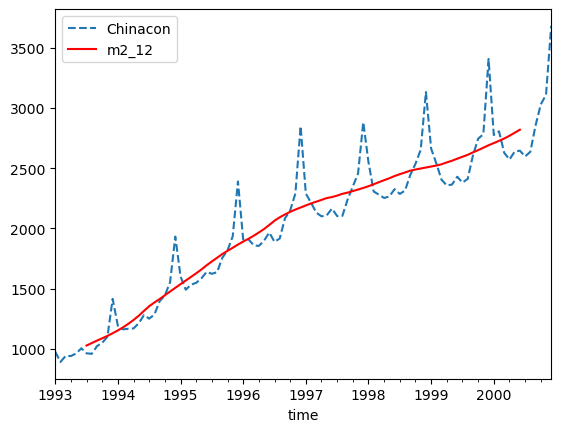

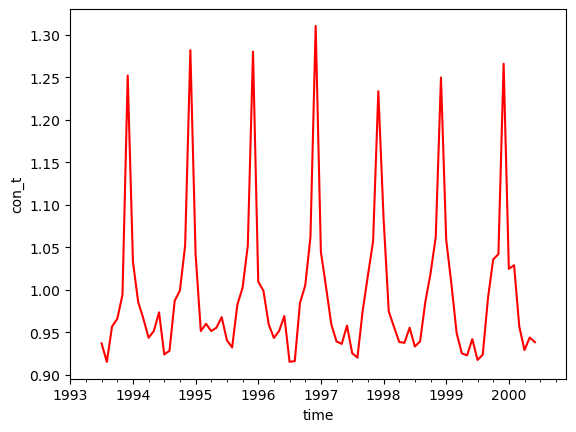

time
1     1.042565
2     0.992670
3     0.958033
4     0.938560
5     0.942680
6     0.957650
7     0.927470
8     0.924893
9     0.980171
10    1.006205
11    1.045898
12    1.267822
Name: con_t, dtype: float64
time
1     1.042565
2     0.992670
3     0.958033
4     0.938560
5     0.942680
6     0.957650
7     0.927470
8     0.924893
9     0.980171
10    1.006205
11    1.045898
12    1.267822
Name: con_t, dtype: float64
0.9987179869901622
Index_season: time
1     1.043903
2     0.993944
3     0.959263
4     0.939764
5     0.943890
6     0.958880
7     0.928660
8     0.926081
9     0.981429
10    1.007497
11    1.047240
12    1.269449
Name: con_t, dtype: float64


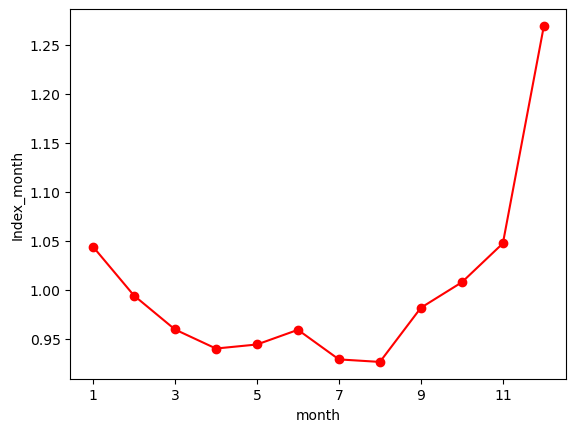

NaN values in Irr: 12


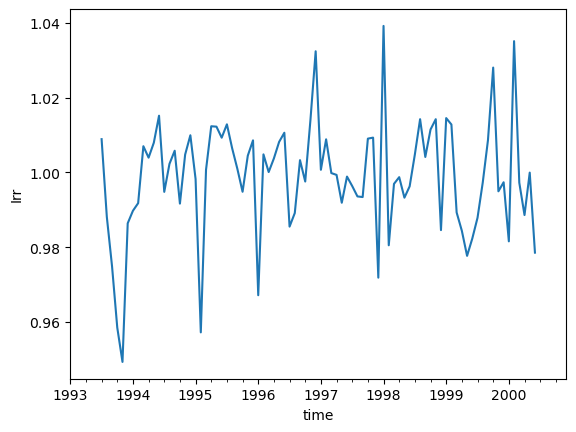

C:\Users\dell\AppData\Local\Temp\ipykernel_16108\479618074.py:113: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout(pad=7.0)


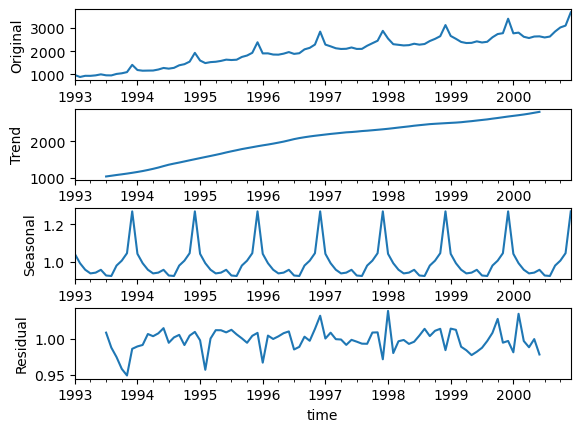

In [2]:
#例2
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from matplotlib import rcParams   
from statsmodels.graphics.tsaplots import plot_acf  # 导入 plot_acf 函数
from statsmodels.graphics.tsaplots import plot_pacf  # 导入 plot_pacf 函数
from statsmodels.stats.diagnostic import acorr_ljungbox  
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.api import SARIMAX 
from statsmodels.tsa.stattools import arma_order_select_ic
import pandas as pd
import matplotlib.pyplot as plt


# 导入数据文件（注意路径中的反斜杠需转义或使用原始字符串）
file17 = pd.read_excel( r'D:\Ts\A1_17.xlsx',  # 使用原始字符串（r前缀）避免转义问题
    parse_dates=True,
    index_col=0
)
 #转换为周期索引（PeriodIndex）
file17 = file17.to_period('M')  # 明确指定周期频率（如'M'表示月度）

#  绘制时序图
file17.plot()

#  显示图形
plt.tight_layout()  # 自动调整布局
plt.show()

# 做12期简单中心移动平均
file17["m12"] = file17.Chinacon.rolling(12, center=True).mean().shift(-1)

# 做2x12复合移动平均
file17["m2_12"] = file17.m12.rolling(2, center=True).mean()

# 显示前12期序列
print(file17.head(12))

#绘制移动平均效果图（见图)
file17.Chinacon.plot(linestyle="--")
file17.m2_12.plot(color="red") 
plt.legend(["Chinacon","m2_12"])
plt.show()  # 显示移动平均效果图

#绘制去掉趋势序列图（见图)
file17["con_t"]=file17.Chinacon/file17.m2_12
file17.con_t.plot(ylabel="con_t",color="red")
plt.show()  # 显示去掉趋势序列图



#计算序列的季度均值
mean_season=file17.con_t.groupby(file17.index.month).mean()
print(mean_season)
#计算序列的总均值
mean_all=file17.con_t.mean()
print(mean_season)
print(mean_all)
#计算季节指数（乘模型季节指数＝季节均值（季度均值）﹣总均值）
Index_season=mean_season/mean_all 
#输出季节指数（季度）
print("Index_season:",Index_season)

# 将索引转换为字符串类型
Index_season.index = Index_season.index.astype(str)

#季节指数图
Index_season.plot(ylabel="Index_month", xlabel="month", marker="o", color='r')
plt.show()  # 显示季节指数图


# 将索引转换为整数类型（关键修正）
Index_season.index = Index_season.index.astype(int)

# 将季节效应赋值给每个序列值
file17["Index_season"] = file17.index.month.map(Index_season)
# 计算随机效应
file17["Irr"] = file17.Chinacon/file17.m2_12/file17.Index_season
# 检查 Irr 列是否存在 NaN 值
print("NaN values in Irr:", file17["Irr"].isna().sum())
# 绘制随机效应图
file17["Irr"].plot()
plt.ylabel("Irr")
plt.show()




#导入 seasonal_decompose 函数
from statsmodels.tsa.api import seasonal_decompose
# 对序列进行乘法模型的因素分解
file17_decompose=seasonal_decompose( file17.Chinacon,period=12,model="multiplicative")
#绘制因素分解图（见图6-11）c
plt.figure()
plt.subplot(4,1,1)
file17.Chinacon.plot(ylabel="Original")

#趋势效应图
plt.subplot(4,1,2)
file17_decompose.trend.plot(ylabel="Trend")
#季节效应图
plt.subplot(4,1,3)
file17_decompose.seasonal.plot(ylabel="Seasonal")

#残差图
plt.subplot(4,1,4)
file17_decompose.resid.plot(ylabel="Residual")

# 使用subplots_adjust来调整子图间距
plt.subplots_adjust(hspace=0.4)  # hspace控制垂直方向上的间距
plt.tight_layout(pad=7.0)
plt.show()

In [4]:
#例2续
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']= False 
from statsmodels.tsa.api import ExponentialSmoothing 
import pandas as pd

fit_x = ExponentialSmoothing(
    file17.Chinacon, trend="add", seasonal="mul", seasonal_periods=12
).fit()

# 打印参数以确认名称
print(fit_x.summary())
# 映射参数名到常用记号
param_map = {
    'smoothing_level': 'alpha',
    'smoothing_trend': 'beta',
    'smoothing_seasonal': 'gamma'
}

# 提取并重命名参数
param_data = {
    v: fit_x.params[k] for k, v in param_map.items() if k in fit_x.params
}
# 添加SSE
param_data['SSE'] = fit_x.sse

# 创建DataFrame
x_params = pd.DataFrame({'fit(LSE)': param_data}).T  # .T 为参数在行
# 或者你喜欢参数名作为行索引
x_params = pd.DataFrame(
    {'fit(LSE)': [param_data.get('alpha'), param_data.get('beta'), param_data.get('gamma'), fit_x.sse]},
    index=['alpha', 'beta', 'gamma', 'SSE']
)

print(x_params)

l_1 = fit_x.level[-1]
t_1 = fit_x.trend[-1]
s_last_cycle = fit_x.season[-12:]
print('a(t)',l_1)
print('b(t)',t_1)
print('s_j(t)',s_last_cycle)

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 Chinacon   No. Observations:                   96
Model:             ExponentialSmoothing   SSE                         150696.676
Optimized:                         True   AIC                            738.433
Trend:                         Additive   BIC                            779.462
Seasonal:                Multiplicative   AICC                           747.316
Seasonal Periods:                    12   Date:                 Tue, 15 Jul 2025
Box-Cox:                          False   Time:                         12:55:36
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4495496                alpha                 True
smoothing_trend          

C:\Users\dell\AppData\Local\Temp\ipykernel_16108\4254373309.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  l_1 = fit_x.level[-1]
C:\Users\dell\AppData\Local\Temp\ipykernel_16108\4254373309.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_1 = fit_x.trend[-1]


2001-01    3096.025934
2001-02    2972.217246
2001-03    2867.827304
2001-04    2825.571338
2001-05    2859.073329
2001-06    2922.982535
2001-07    2848.899011
2001-08    2874.123452
2001-09    3079.458485
2001-10    3212.786477
2001-11    3335.791254
2001-12    4016.519073
Freq: M, dtype: float64


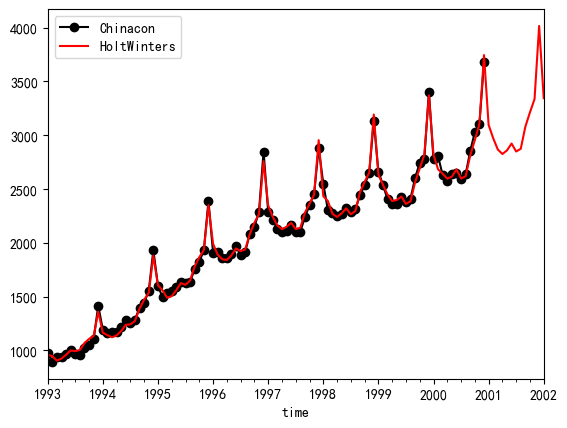

In [5]:
#基于 Holt - Winters 三参数指数平滑模型，12期预测，并输出预测结果
pred=fit_x.predict(0,len (file17)+12)
print(pred[len(file17):len(file17)+12])

#绘制预测效果图（见图6-17
file17.Chinacon.plot (color="black", marker ="o", legend=True )
pred.plot(color="red",legend=True, label="HoltWinters")
plt.show()

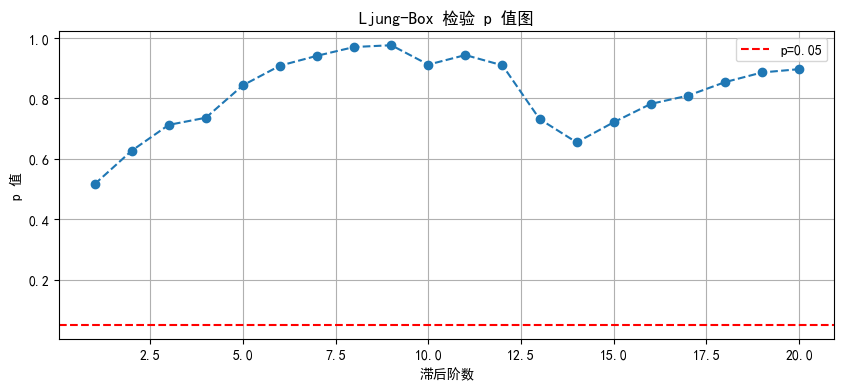

NameError: name 'data' is not defined

In [9]:
#残差诊断
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib import rcParams
# 设置中文字体为 SimHei（黑体），并解决负号显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

def LB_plot(residuals, lags=20):
    """
    绘制残差的 Ljung-Box 检验结果图
    residuals: 模型残差（必须是 pandas Series）
    lags: 最大滞后阶数
    """
    lb_test = acorr_ljungbox(residuals, lags=lags, return_df=True)
    p_values = lb_test['lb_pvalue']

    plt.figure(figsize=(10, 4))
    plt.plot(range(1, lags + 1), p_values, marker='o', linestyle='--')
    plt.axhline(0.05, color='red', linestyle='--', label='p=0.05')
    plt.title('Ljung-Box 检验 p 值图')
    plt.xlabel('滞后阶数')
    plt.ylabel('p 值')
    plt.grid(True)
    plt.legend()
    plt.show()


# 假设 x_fit 是已经拟合好的模型
residuals = fit_x.resid  # 提取残差
LB_plot(residuals, 20)

#模型预测
fore = fit_x.predict(start=len(data), end=len(data)+11)
fore.summary_frame()